# Linear Regression: Prostate Cancer Example

The data below comes from a study by Stamey et al. (1989), which examines the correlation between the level of prostate-specific antigen (PSA). The example is covered in Section 3.2.1 if Hastie et al. *Elements of Statistical Learning*.

In [1]:
import pandas as pd
df = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data", sep='\t')

In [2]:
df = df.drop(columns=['Unnamed: 0'])
df.head(5)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
df_train = df[df['train']=='T']
df_test = df[df['train']=='F']

67 samples for training, 30 for testing.

In [4]:
df_train.shape

(67, 10)

In [5]:
df_test.shape

(30, 10)

运行 df_train.corr() 时，pandas 会尝试对 DataFrame 中的所有列进行相关性计算。相关性计算只适用于数值型数据（如整数、浮点数）

In [7]:
df_train.drop(columns=['train']).corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161,0.733155
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166,0.485215
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806,0.227642
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404,0.262938
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358,0.556886
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533,0.489203
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056,0.342428
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000,0.448048
lpsa,0.733155,0.485215,0.227642,0.262938,0.556886,0.489203,0.342428,0.448048,1.000000


In [10]:
df_train.select_dtypes(include='number').corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161,0.733155
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166,0.485215
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806,0.227642
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404,0.262938
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358,0.556886
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533,0.489203
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056,0.342428
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000,0.448048
lpsa,0.733155,0.485215,0.227642,0.262938,0.556886,0.489203,0.342428,0.448048,1.000000


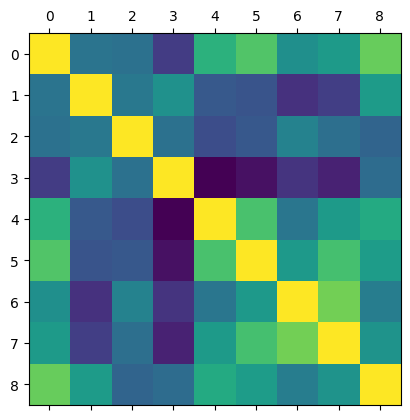

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.matshow(df_train.drop(columns=['train']).corr())

In [13]:
df.describe().loc[['mean', 'std']] # 对 DataFrame df 的所有数值型列进行统计汇总

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329


## Linear Regression: Training, Evaluation, Feature Importance

perform linear regression on the dataset using Python's scikit-learn library. We import the library and create an instance of a Linear Regression class.

In [14]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

regr = linear_model.LinearRegression()

We must normalize our features to have mean 0 and standard deviation of 1, up to computational errors.
Importantly, we need to normalize train and test sets separately, using means and sds of train set's columns for normalizing test set. For an explanation on why: https://sebastianraschka.com/faq/docs/scale-training-test.html

In [15]:
def normalize(df, scaler=None):
    '''
    If scaler is not none, use given scaler's means and sds to normalize (used for test set case)
    '''
    #Will not normalize the response (or outcomes), only the predictors (features)

    #Normalizing train set
    if(scaler is None):
      scaler = StandardScaler()
      normalized_features = scaler.fit_transform(pd.DataFrame(df.iloc[:,:-1])) 
    #Normalizing test set
    else:
      normalized_features = scaler.transform(pd.DataFrame(df.iloc[:,:-1]))
        
    outcomes = df.iloc[:,-1]
    normalized_df = pd.DataFrame(normalized_features)
      
    # Recover the outcomes column
    normalized_df['outcome'] = outcomes.tolist() # use .tolist() to avoid conflict given different index between normalized_df and outcomes
    
    # Recover the original indices and column names                                          
    normalized_df.index=df.index
    normalized_df.columns=df.columns

    return normalized_df, scaler
  
#Normalize training
df_train_train_column = df_train['train']
df_train, scaler = normalize(df_train.drop(columns=['train']))
df_train['train'] = df_train_train_column

如果没有传入 scaler，说明是训练集，先新建一个 StandardScaler，并用训练集的特征数据 fit_transform（即计算均值和方差并标准化）。

如果传入了 scaler，说明是测试集，用训练集的均值和方差 transform 测试集特征

In [16]:
df_train.describe().loc[['mean', 'std']]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
mean,4.971148e-17,9.378899e-16,-8.343243e-16,6.628197e-18,3.976918e-17,-4.308328e-17,4.921436e-16,-3.314099e-17,2.452345
std,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.207812


In [17]:
#Normalize test, using scaler from train set normalization
df_test_train_column = df_test['train']
df_test, _ = normalize(df_test.drop(columns=['train']), scaler)
df_test['train'] = df_test_train_column

In [18]:
df_test.describe().loc[['mean', 'std']]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
mean,0.095740,0.019378,-0.382254,0.064359,-0.057289,0.081023,0.097586,-0.209818,2.536547
std,0.840554,0.636143,0.945937,0.994212,0.975998,1.016637,1.081828,0.878424,1.042035


### Creating the inputs and targets

In [19]:
train_features = df_train.loc[:,'lcavol':'pgg45']
train_targets = df_train.loc[:,'lpsa']

test_features = df_test.loc[:,'lcavol':'pgg45']
test_targets = df_test.loc[:,'lpsa']

In [20]:
train_features.head(1)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,-1.53518,-1.810979,-1.980425,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253


### Training the model

In [21]:
regr.fit(train_features,train_targets)

LinearRegression()

### Evaluating the model

预测值 target_predict 和真实值 test_targets 之间的均方误差（MSE, Mean Squared Error）

In [22]:
target_predict = regr.predict(test_features)

* *Mean squared error* represents a measure of prediction error. 
* *Variance score* is the coefficient of prediction (R^2)

RSS = ∑(预测值 - 真实值)²  所有预测误差的平方和，越小越好。

方差解释度（R²分数，coefficient of determination）模型对数据方差的解释能力，越接近 1 越好。

Mean squared error (MSE)：平均预测误差的平方，越小越好。

In [23]:
# The mean squared error and RSS (by hand)
print("Mean squared error: %.2f" % np.mean((target_predict - test_targets) ** 2))
print("RSS: %.2f" % np.sum((target_predict - test_targets) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(train_features, train_targets))

Mean squared error: 0.52
RSS: 15.64
Variance score: 0.69


In [24]:
mean_squared_error(target_predict,test_targets)

0.5212740055076002

In [25]:
def Z_score(X_train, y_true, y_pred, beta_hat):
    '''
    Returns the Z-scores of the model with coefficients beta_hat.
    The data is encoded in X_train and y_true:
        X_train is a (numpy) array (N, p + 1), where p is the number of predictors.
        y_true is a vector of length N.
    y_pred ia vector of length N, and is the prediction of the model on X.
    '''
    N = len(y_true)
    p = X_train.shape[1] - 1
    variance_y_est = (1/(N-p-1)) * np.sum(np.square(y_true - y_pred)) # Estimative of the variance of y.
    diag = np.diag(np.linalg.inv(np.matmul(np.transpose(X_train),X_train))) # Diagonal of (X^t X)^{-1}.
    Z = (1/np.sqrt(variance_y_est)) * np.multiply(beta_hat, np.sqrt(1/diag))
    return Z

In [26]:
# The predicted values of y on the training set.
y_pred = regr.predict(train_features)

# prepare beta
beta_hat = regr.coef_
beta_hat = np.concatenate([np.array([regr.intercept_]), beta_hat])

# prepare X
column_of_ones = np.ones((train_features.shape[0],1))
X = np.concatenate([column_of_ones, train_features], axis = 1)

# Z-scores 
columns = ['Intercept'] + train_features.columns.to_list()
Zscores = np.array([Z_score(X, train_targets.to_numpy(), y_pred, beta_hat)])
Zscores_df = pd.DataFrame(data=Zscores, columns=columns, index=['Z-score'] )
Zscores_df

,Intercept,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
Z-score,28.181527,5.36629,2.750789,-1.395909,2.055846,2.469255,-1.866913,-0.146681,1.73784


### Dropping less significant features

标准化系数的绝对值越大（即相对于标准偏差进行归一化），反映出特征的重要性越高

In [27]:
print('Intercept: \n', regr.intercept_, '\nCoefficients: \n', regr.coef_)

Intercept: 
 2.4523450850746262 
Coefficients: 
 [ 0.71104059  0.29045029 -0.14148182  0.21041951  0.30730025 -0.28684075
 -0.02075686  0.27526843]


In [28]:
train_features_small = df_train.loc[:,['lcavol','lweight','svi']]
test_features_small = df_test.loc[:,['lcavol','lweight','svi']]
regr.fit(train_features_small,train_targets)
target_predict_small = regr.predict(test_features_small)

# The mean squared error and RSS (by hand)
print("Mean squared error: %.2f" % np.mean((target_predict_small - test_targets) ** 2))
print("RSS: %.2f" % np.sum((target_predict_small - test_targets) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(train_features_small, train_targets))

Mean squared error: 0.40
RSS: 12.02
Variance score: 0.64
